In [1]:
import pandas as pd
from multiprocessing.pool import ThreadPool as Pool 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import pickle
from flask import Flask, request 
from scipy.sparse import hstack
from sklearn import metrics
import numpy as np

# (3) Learn to rank -- pg.61-68

In [2]:
anime = pd.read_csv('resource/anime.csv') 
rating = pd.read_csv('resource/anime_rating_1000_users.csv') 
anime_features = ['MAL_ID','English name','Japanese name','Score','Genres','Popularity', 
            'Members','Favorites','Watching','Completed','On-Hold','Dropped', 
            'Score-1','Score-2','Score-3','Score-4','Score-5', 
            'Score-6','Score-7','Score-8','Score-9','Score-10', 
            ] 
anime = anime[anime_features] 

#%% 

merged_df = anime.merge(rating, left_on='MAL_ID', right_on='anime_id', how='inner') 

#%% 

genre_names = [ 
        'Action', 'Adventure','Comedy', 'Drama','Sci-Fi', 
        'Game', 'Space', 'Music', 'Mystery', 'School', 'Fantasy', 
        'Horror', 'Kids', 'Sports', 'Magic', 'Romance', 
        ]

In [3]:
anime

,MAL_ID,English name,Japanese name,Score,Genres,Popularity,Members,Favorites,Watching,Completed,...,Score-1,Score-2,Score-3,Score-4,Score-5,Score-6,Score-7,Score-8,Score-9,Score-10
0,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,1580.0,741.0,1357.0,3184.0,8904.0,20688.0,62330.0,131625.0,182126.0,229170.0
1,5,Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,8.39,"Action, Drama, Mystery, Sci-Fi, Space",518,273145,1174,4143,208333,...,379.0,109.0,221.0,577.0,1877.0,5805.0,22632.0,49505.0,49201.0,30043.0
2,6,Trigun,トライガン,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",201,558913,12944,29113,343492,...,533.0,316.0,664.0,1965.0,5838.0,15376.0,49432.0,86142.0,75651.0,50229.0
3,7,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.27,"Action, Mystery, Police, Supernatural, Drama, ...",1467,94683,587,4300,46165,...,131.0,164.0,353.0,1083.0,2920.0,5709.0,11618.0,10128.0,4806.0,2182.0
4,8,Beet the Vandel Buster,冒険王ビィト,6.98,"Adventure, Fantasy, Shounen, Supernatural",4369,13224,18,642,7314,...,27.0,50.0,83.0,265.0,634.0,1068.0,1713.0,1242.0,529.0,312.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,48481,Unknown,盗墓笔记之秦岭神树,Unknown,"Adventure, Mystery, Supernatural",13116,354,6,0,0,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,1.0,Unknown,Unknown,Unknown
17558,48483,Unknown,見える子ちゃん,Unknown,"Comedy, Horror, Supernatural",17562,7010,70,14,0,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
17559,48488,Higurashi:When They Cry – SOTSU,ひぐらしのなく頃に卒,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",17558,11309,48,3,0,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,1.0
17560,48491,Unknown,ヤマノススメ Next Summit,Unknown,"Adventure, Slice of Life, Comedy",17565,1386,2,13,2,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


In [4]:
def genre_to_category(df): 
    '''Add genre cagegory column 
    ''' 
    d = {name :[] for name in genre_names} 

    def f(row): 
        genres = row.Genres.split(',') 
        for genre in genre_names: 
            if genre in genres: 
                d[genre].append(1) 
            else: 
                d[genre].append(0) 
    # create genre category dict 
    df.apply(f, axis=1) 

    # add genre category 
    genre_df = pd.DataFrame(d, columns=genre_names) 
    df = pd.concat([df, genre_df], axis=1) 
    return df 

def make_anime_feature(df): 
    # convert object to a numeric type, replacing Unknown with nan. 
    df['Score'] = df['Score'].apply(lambda x: np.nan if x=='Unknown' else float(x)) 
    for i in range(1, 11): 
        df[f'Score-{i}'] = df[f'Score-{i}'].apply(lambda x: np.nan if x=='Unknown' else float(x)) 
    # add genre ctegory columns 
    df = genre_to_category(df) 
    
    return df

In [5]:
def make_user_feature(df):
    df['rating_count'] = df.groupby('user_id')['anime_id'].transform('count')
    df['rating_mean'] = df.groupby('user_id')['rating'].transform('mean')
    return df
    
def preprocess(merged_df):
    merged_df = make_anime_feature(merged_df)
    merged_df = make_user_feature(merged_df)
    return merged_df

In [6]:
merged_df = preprocess(merged_df)
merged_df = merged_df.drop(['MAL_ID','Genres'], axis=1)

In [7]:
fit, blindtest = train_test_split(merged_df, test_size=0.2, random_state=0) 
fit_train, fit_test = train_test_split(fit, test_size=0.3, random_state=0) 

features = ['Score', 'Popularity','Members', 
        'Favorites','Watching','Completed','On-Hold','Dropped', 
        'Score-1','Score-2','Score-3','Score-4','Score-5', 
        'Score-6','Score-7','Score-8','Score-9','Score-10', 
        'rating_count','rating_mean' 
        ] 

features += genre_names 
user_col = 'user_id' 
item_col = 'anime_id' 
target_col = 'rating' 

fit_train = fit_train.sort_values('user_id').reset_index(drop=True) 
fit_test = fit_test.sort_values('user_id').reset_index(drop=True) 
blindtest = blindtest.sort_values('user_id').reset_index(drop=True) 

# model query data 
fit_train_query = fit_train[user_col].value_counts().sort_index() 
fit_test_query = fit_test[user_col].value_counts().sort_index() 
blindtest_query = blindtest[user_col].value_counts().sort_index() 

In [8]:
model = lgb.LGBMRanker(n_estimators=1000, random_state=0) 
model.fit( 
    fit_train[features], 
    fit_train[target_col], 
    group=fit_train_query, 
    eval_set=[(fit_test[features], fit_test[target_col])], 
    eval_group=[list(fit_test_query)], 
    eval_at=[1, 3, 5, 10], # calc validation ndcg@1,3,5,10 
    # early_stopping=100, 
    # best_iteration_=10 
) 

#%% 

model.predict(blindtest.iloc[:10][features])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 92019, number of used features: 36


array([ 0.81364265, -0.34881657, -0.41796969, -0.9213266 , -1.99305561,
       -4.06760536, -3.72715985, -0.6545309 , -0.91256783, -1.25944641])

Text(0.5, 1.0, 'feature importance')

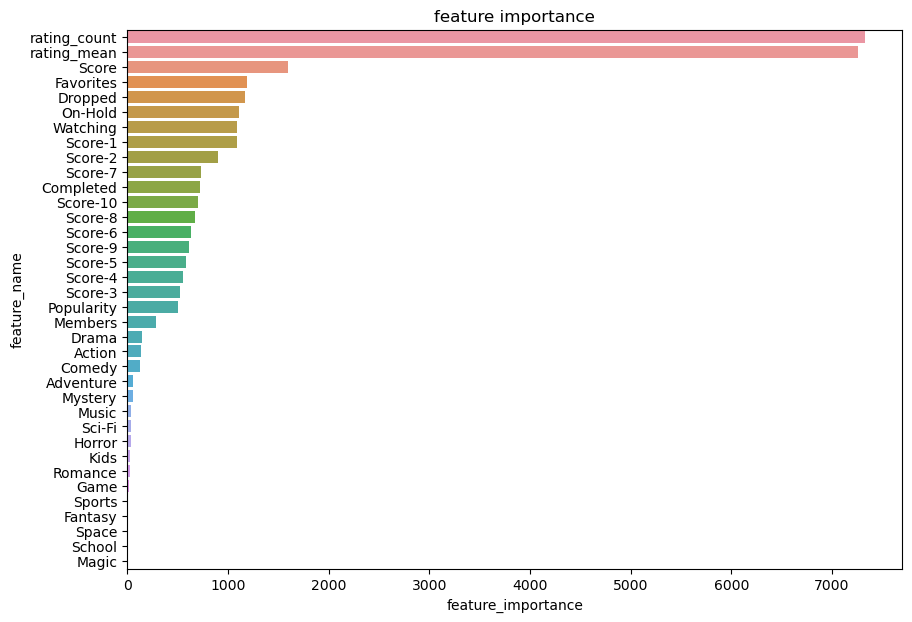

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
df_plt = pd.DataFrame({'feature_name': features, 'feature_importance':model.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x='feature_importance', y='feature_name', data=df_plt)
plt.title('feature importance')



In [10]:
def predict(user_df, top_k, anime, rating):
    user_anime_df = anime.merge(user_df, left_on='MAL_ID', right_on='anime_id')
    user_anime_df = make_anime_feature(user_anime_df)

    excludes_genres = list(np.array(genre_names)[np.nonzero([user_anime_df[genre_names].sum(axis=0)<= 1])[1]])

    pred_df = make_anime_feature(anime.copy())
    pred_df = pred_df.loc[pred_df[excludes_genres].sum(axis=1)==0]

    for col in user_df.columns:
        if col in features:
            pred_df[col] = user_df[col].values[0]

    preds = model.predict(pred_df[features])

    topk_idx = np.argsort(preds)[::-1][:top_k]

    recommend_df = pred_df.iloc[topk_idx].reset_index(drop=True)

    # check recommend
    print('---------- Recommend ----------')
    for i, row in recommend_df.iterrows():
        print(f'{i+1}: {row["Japanese name"]}:{row["English name"]}')

    print('---------- Rated ----------')
    user_df = user_df.merge(anime, left_on='anime_id', right_on='MAL_ID', how='inner')
    for i, row in user_df.sort_values('rating',ascending=False).iterrows():
        print(f'rating:{row["rating"]}: {row["Japanese name"]}:{row["English name"]}')

    return recommend_df 

In [11]:
user_df = rating.copy().loc[rating['user_id'] == 1]
user_df = make_user_feature(user_df)
predict(user_df, 10, anime, rating)

---------- Recommend ----------
1: 進撃の巨人 The Final Season:Attack on Titan Final Season
2: 銀河英雄伝説:Legend of the Galactic Heroes
3: 無職転生 ～異世界行ったら本気だす～:Mushoku Tensei:Jobless Reincarnation
4: ホリミヤ:Horimiya
5: 天官赐福特别节目:Unknown
6: 呪術廻戦:Unknown
7: Re：ゼロから始める異世界生活:Unknown
8: こんにちは アン ～Before Green Gables:Before Green Gables
9: 約束のネバーランド:The Promised Neverland Season 2
10: 銀魂 THE SEMI-FINAL:Unknown
---------- Rated ----------
rating:10: シュタインズ・ゲート ゼロ:Steins;Gate 0
rating:10: 千と千尋の神隠し:Spirited Away
rating:10: 君の名は。:Your Name.
rating:10: 鋼の錬金術師 FULLMETAL ALCHEMIST:Fullmetal Alchemist:Brotherhood
rating:10: STEINS;GATE:Steins;Gate
rating:10: シュタインズ・ゲート境界面上のミッシングリンク-Divide By Zero-:Unknown
rating:10: ナルト- 疾風伝:Naruto:Shippuden
rating:10: コードギアス 反逆のルルーシュ:Code Geass:Lelouch of the Rebellion
rating:10: 進撃の巨人:Attack on Titan
rating:10: 進撃の巨人 Season2:Attack on Titan Season 2
rating:10: 進撃の巨人 Season3:Attack on Titan Season 3
rating:10: 青春ブタ野郎はバニーガール先輩の夢を見ない:Rascal Does Not Dream of Bunny Girl Senpai
rati

,MAL_ID,English name,Japanese name,Score,Genres,Popularity,Members,Favorites,Watching,Completed,...,Mystery,School,Fantasy,Horror,Kids,Sports,Magic,Romance,rating_count,rating_mean
0,40028,Attack on Titan Final Season,進撃の巨人 The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",119,733260,44862,566239,553,...,0,0,0,0,0,0,0,0,103,8.058252
1,820,Legend of the Galactic Heroes,銀河英雄伝説,9.07,"Military, Sci-Fi, Space, Drama",633,230168,13834,25968,52583,...,0,0,0,0,0,0,0,0,103,8.058252
2,39535,Mushoku Tensei:Jobless Reincarnation,無職転生 ～異世界行ったら本気だす～,8.37,"Drama, Magic, Fantasy",438,319654,5411,213381,39,...,0,0,0,0,0,0,0,0,103,8.058252
3,42897,Horimiya,ホリミヤ,8.60,"Slice of Life, Comedy, Romance, School, Shounen",366,363936,9065,245814,189,...,0,0,0,0,0,0,0,0,103,8.058252
4,44070,Unknown,天官赐福特别节目,7.98,"Historical, Supernatural, Drama",6329,5274,79,92,625,...,0,0,0,0,0,0,0,0,103,8.058252
5,40748,Unknown,呪術廻戦,8.54,"Action, Demons, Supernatural, School, Shounen",130,707976,20816,533016,299,...,0,0,0,0,0,0,0,0,103,8.058252
6,42203,Unknown,Re：ゼロから始める異世界生活,8.64,"Psychological, Drama, Thriller, Fantasy",399,342829,5059,214713,51,...,0,0,0,0,0,0,0,0,103,8.058252
7,5494,Before Green Gables,こんにちは アン ～Before Green Gables,7.59,"Drama, Historical, Kids, Slice of Life",6273,5394,27,296,1822,...,0,0,0,0,0,0,0,0,103,8.058252
8,39617,The Promised Neverland Season 2,約束のネバーランド,7.49,"Sci-Fi, Mystery, Psychological, Thriller, Shounen",248,482725,5090,260775,60,...,0,0,0,0,0,0,0,0,103,8.058252
9,44087,Unknown,銀魂 THE SEMI-FINAL,8.58,"Action, Comedy, Historical, Parody, Samurai, S...",3714,19351,146,1161,4103,...,0,0,0,0,0,0,0,0,103,8.058252
